## Хакатон по распознаванию хот-догов. 
По мотивам крутейшего стартапа из сериала "кремниевая долина"!

https://www.youtube.com/watch?v=pqTntG1RXSY


Ваша задача: сделать революционный классификатор, который сразил большинство инвесторов и гиков из кремниевой долины не один раз!

Точнее, вам необходимо предсказать, есть на изображении хот-дог или нет. В файл с решением необходимо записать вероятность того, что на изображении **есть хот-дог**.

Качество модели будет измеряться с помощью метрики AUC-ROC, публичный лидерборд (рейтинговая таблица соревнования на платформе kaggle) будет строиться по 50% наблюдений. 

Чуть подробнее про публичный и приватный лидерборд: вам дана тестовая выборка, для которой неизвестна целевая переменная. Вы обучаете модель, предсказываете для тестовой выборки, формируете из предсказаний csv-файл, и загружаете его на платформу kaggle. Видите значение метрики AUC-ROC. Это значение называется метрикой на публичном лидерборде, и считается оно не по всем данным, а лишь по 50% от тестовой выборки. Когда соревнование заканчивается, AUC-ROC пересчитывается уже для 100% тестовой выборки, и это уже называется приватный лидерборд, он же - финальный.

Такой подход является классическим для большей части соревнований по анализу данных, и основан он на том, что если не делать такого разделения, то будет происходить неявное переобучение модели под тестовую выборку. 

На этом вводная часть заканчивается, и мы искренне желаем вам удачи :) <br>
Сможете ли вы повторить успех Jian Yuang'a? Мы в вас верим!

<hr>

## Unzip Data and Import Libraries

In [1]:
# TF libraries
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import efficientnet.keras as efn
from keras.utils import plot_model

# ML libraries
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
font = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 22,
}

## Data Upload

In [3]:
SEED = 257

TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

In [4]:
categories = ['hot dog', 'not hot dog']

In [5]:
X, y = [], []

for category in categories:
    category_dir = os.path.join(TRAIN_DIR, category)
    for image_path in os.listdir(category_dir):
        X.append(imread(os.path.join(category_dir, image_path)))
        y.append(category)

## Train-Test Split

In [6]:
y = [1 if x == 'hot dog' else 0 for x in y]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.25, random_state=SEED)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7536, 100, 100, 3), (2512, 100, 100, 3), (7536,), (2512,))

## CNN Setup

In [9]:
# CNN architecture
efficient_net = efn.EfficientNetB3(
    weights='imagenet',
    input_shape=(100,100,3),
    include_top=False,
    pooling='max'
)

HOTDOG_DESTROYER = Sequential()
HOTDOG_DESTROYER.add(efficient_net)

HOTDOG_DESTROYER.add(Dense(128, activation='relu'))
HOTDOG_DESTROYER.add(BatchNormalization())
HOTDOG_DESTROYER.add(Dropout(0.3))

HOTDOG_DESTROYER.add(Dense(128, activation='relu'))
HOTDOG_DESTROYER.add(BatchNormalization())
HOTDOG_DESTROYER.add(Dropout(0.3))

HOTDOG_DESTROYER.add(Dense(64, activation='relu'))
HOTDOG_DESTROYER.add(BatchNormalization())

HOTDOG_DESTROYER.add(Dense(units = 1, activation='sigmoid'))

In [10]:
# Compiler and summary
HOTDOG_DESTROYER.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

HOTDOG_DESTROYER.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 1536)              10783528  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [11]:
# Model fit
history = HOTDOG_DESTROYER.fit(
    X_train, y_train,
    batch_size=32,
    epochs=150,
    verbose=1,
    validation_data=(X_test, y_test)
) 

Train on 7536 samples, validate on 2512 samples
Epoch 150/150
7536/7536 [==============================] - 147s 20ms/step - loss: 0.0181 - accuracy: 0.9952 - val_loss: 0.2238 - val_accuracy: 0.9518


In [12]:
# Evaluation
score = HOTDOG_DESTROYER.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22382189998637506
Test accuracy: 0.9518312215805054


In [13]:
# ROC-AUC score
roc_auc_score(y_test, HOTDOG_DESTROYER.predict_proba(X_test))

0.9541210798309347

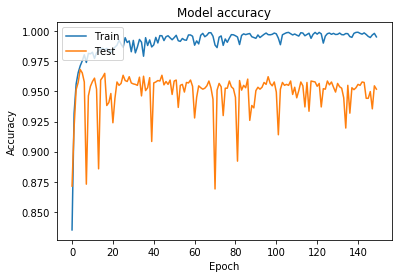

<Figure size 432x288 with 0 Axes>

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('Accuracy')

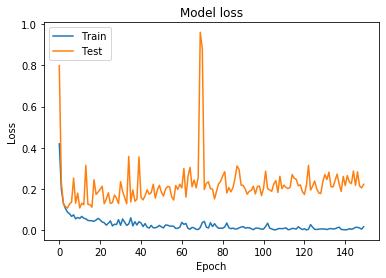

In [35]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions

In [23]:
leaderboard_X = []  
leaderboard_filenames = []

In [24]:
for image_path in os.listdir(TEST_DIR):
    leaderboard_X.append(imread(os.path.join(TEST_DIR, image_path)))
    leaderboard_filenames.append(image_path)

Глянем, что тут у нас вкусного в выборке для leaderboard?

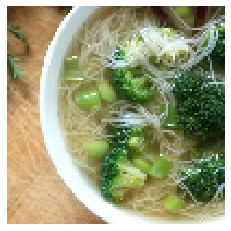

In [25]:
plt.axis("off");
plt.imshow(leaderboard_X[0]);

In [26]:
print(leaderboard_X[0].shape, leaderboard_filenames[0])

(100, 100, 3) 0003a33387289b715622ad0c3e2b5e8ba075269ad61c80b76185e40b7e33bf1c.png


In [27]:
leaderboard_X = np.array(leaderboard_X)
pred = HOTDOG_DESTROYER.predict(leaderboard_X)
pred.tolist()
leadeboard_predictions = []

for i in range(len(pred)):
    leadeboard_predictions.append(float(pred[i]))
  
leadeboard_predictions

[5.209201390243834e-07,
 0.029833652079105377,
 0.004400048404932022,
 0.0014937060186639428,
 1.576108843437396e-06,
 0.0001716037659207359,
 0.9929308891296387,
 0.853899359703064,
 0.00039970091893337667,
 0.0001466189423808828,
 8.70930634278011e-08,
 0.0001541099773021415,
 2.1410275508060295e-07,
 9.6767769264261e-07,
 0.000191195635125041,
 0.22686146199703217,
 0.0002521528513170779,
 9.080931340577081e-05,
 9.520622370473575e-07,
 0.0009583799401298165,
 3.885881960741244e-05,
 3.648836965908231e-08,
 0.16610434651374817,
 0.004422514699399471,
 0.0004403845523484051,
 0.00018623677897267044,
 3.838636985165067e-06,
 0.00010939961794065312,
 0.0006040720036253333,
 2.8809712603106163e-05,
 1.2159517837062594e-07,
 0.00021466227190103382,
 0.0036576197016984224,
 6.96004499332048e-05,
 0.015703946352005005,
 0.0008274118299596012,
 0.0001499814970884472,
 1.2751057738569216e-06,
 0.00431270943954587,
 0.998126208782196,
 7.064938108669594e-05,
 3.5153036606061505e-06,
 0.262134

In [28]:
pred.round(8)

array([[5.2000001e-07],
       [2.9833650e-02],
       [4.4000498e-03],
       ...,
       [9.9105775e-01],
       [1.3815860e-01],
       [9.9886960e-01]], dtype=float32)

Посмотрим, как бы работало наше приложение :)<br>
Вы можете менять значение переменной ```idx```, и смотреть, что предсказывает модель на различных изображениях.

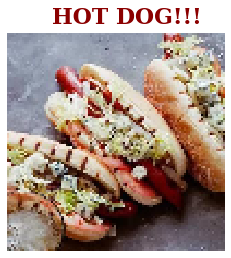

In [29]:
idx = 519

plt.axis("off");
if leadeboard_predictions[idx] > 0.5:
    plt.text(20, -5, 'HOT DOG!!!', fontdict=font)
else:
    plt.text(15, -5,'not hot dog...', fontdict=font)
plt.imshow(leaderboard_X[idx]);

Формируем DataFrame, содержащий наше решение

In [30]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
submission = pd.DataFrame(
    {
        'image_id': leaderboard_filenames, 
        'image_hot_dog_probability': leadeboard_predictions
    }
)

In [31]:
submission.head()

,image_id,image_hot_dog_probability
0,0003a33387289b715622ad0c3e2b5e8ba075269ad61c80...,0.0000005209
1,000ac21f4a7ead096d4797eed62fbe308665044e27d550...,0.0298336521
2,000ef9d107017bb2190a88a5c70adeb5941f22ab7a952f...,0.0044000484
3,002c5ef1a07ee819724f2e548a6e036908abc784d7ff59...,0.0014937060
4,003f5ca3f01c6a94b51dc8b019261e827b2dd2888a2ce9...,0.0000015761


Сохраним результат в submit.csv, который нужно отправить на kaggle. Сделайте это!

Ссылку на соревнование вы можете получить у своего куратора. 

In [32]:
submission.to_csv('HOTDOG_DESTROYER.csv', index=False, float_format='%.10f')

### Идеи для развития и улучшения модели!

1. Попробуйте в качестве модели сверточную нейронную сеть: экспериментируйте с архитектурами, алгоритмами оптимизации. 
2. Сделайте аугментацию (data augmentation) обучающей выборки. 
3. Найдите больше данных и используйте их для обучения модели! Только не забывайте о том, что распределение классов hot-dog \ not hot-dog должно оставаться на прежнем уровне. 
4. Используйте технику transfer learning: ее идея заключается в дообучении на ваших данных модели, хорошо работающей на каком-либо датасете (в изображениях это обычно ImageNet). Стоит обратить внимание на модели семейства ResNet. 
5. Посмотрите в сторону блендинга (blending) - это способ, позволяющий объединить предсказания нескольких моделей, что в результате может вам дать более устойчивый классификатор